# V4: 俳句モデル - 推論アニメーション

日本語俳句生成の推論プロセスを可視化し、トークン生成の各ステップでモデル内部がどう動作しているかを理解します。

このNotebookでは以下を実装しています：
- 基本的なステップ情報の表示
- **Plotlyインタラクティブアニメーション**（再生/停止/スライダー制御）
- モデル構造フローの動的可視化

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from model_analyzer import ModelAnalyzer, InferenceEngine

# Seabornのスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
import japanize_matplotlib  # 日本語表示を有効化


## ModelAnalyzerとInferenceEngineの初期化

In [2]:
# 俳句モデルの読み込み
analyzer = ModelAnalyzer('../haiku_orgparam_model.json')
engine = InferenceEngine(analyzer)

モデル読み込み完了: vocab_size=2345, n_layer=1, n_embd=16, block_size=16, n_head=4


## 推論実行と中間状態の記録

In [3]:
# 推論パラメータ
input_text = ""  # 空文字列でBOSから開始
max_length = 5
temperature = 0.5

# 推論実行（中間状態を記録）
generated_text, all_states = engine.run_inference(
    input_text=input_text,
    max_length=max_length,
    temperature=temperature,
    record_states=True
)

print(f"生成された俳句フラグメント: {generated_text}")
print(f"ステップ数: {len(all_states)}")

生成された俳句フラグメント: 秋になてら
ステップ数: 5


## 各ステップの詳細可視化

In [4]:
# 各ステップを順に表示
for step_idx, states in enumerate(all_states):
    print("\n" + "=" * 70)
    print(f"ステップ {step_idx + 1}")
    print("=" * 70)
    
    # 現在のトークン情報
    token_id = states['token_id']
    pos_id = states['pos_id']
    next_token_id = states['next_token_id']
    
    if token_id == analyzer.BOS:
        current_char = '<BOS>'
    else:
        current_char = analyzer.uchars[token_id]
    
    if next_token_id == analyzer.BOS:
        next_char = '<BOS>'
    else:
        next_char = analyzer.uchars[next_token_id]
    
    print(f"現在のトークン: '{current_char}' (ID: {token_id}, 位置: {pos_id})")
    print(f"次のトークン: '{next_char}' (ID: {next_token_id})")
    
    # Embedding統計
    emb = states['embedding']
    print(f"\nEmbedding統計:")
    print(f"  平均: {np.mean(emb):.4f}")
    print(f"  標準偏差: {np.std(emb):.4f}")
    print(f"  最小値: {np.min(emb):.4f}")
    print(f"  最大値: {np.max(emb):.4f}")
    
    # Attention重み（各レイヤー、各ヘッド）
    for li in range(analyzer.n_layer):
        attn_weights = states[f'layer{li}_attn_weights']
        print(f"\nLayer {li} Attention:")
        for h in range(analyzer.n_head):
            weights = attn_weights[h]
            max_attn_idx = np.argmax(weights)
            max_attn_weight = weights[max_attn_idx]
            print(f"  ヘッド {h}: 最も注目 → 位置 {max_attn_idx} (重み: {max_attn_weight:.4f})")
    
    # MLP出力統計
    for li in range(analyzer.n_layer):
        mlp_out = states[f'layer{li}_mlp_out']
        print(f"\nLayer {li} MLP出力統計:")
        print(f"  平均: {np.mean(mlp_out):.4f}")
        print(f"  最大値: {np.max(mlp_out):.4f}")
    
    # 次トークン確率分布（上位5件）
    probs = states['probs']
    top_k = 5
    top_indices = np.argsort(probs)[-top_k:][::-1]
    
    print(f"\n次トークン確率分布（上位{top_k}件）:")
    for rank, idx in enumerate(top_indices, 1):
        if idx == analyzer.BOS:
            char = '<BOS>'
        else:
            char = analyzer.uchars[idx]
        prob = probs[idx]
        selected = "★" if idx == next_token_id else "  "
        print(f"  {selected} {rank}. '{char}': {prob:.4f}")


ステップ 1
現在のトークン: '<BOS>' (ID: 2344, 位置: 0)
次のトークン: '秋' (ID: 1458)

Embedding統計:
  平均: 0.1230
  標準偏差: 0.9924
  最小値: -1.1265
  最大値: 3.1822

Layer 0 Attention:
  ヘッド 0: 最も注目 → 位置 0 (重み: 1.0000)
  ヘッド 1: 最も注目 → 位置 0 (重み: 1.0000)
  ヘッド 2: 最も注目 → 位置 0 (重み: 1.0000)
  ヘッド 3: 最も注目 → 位置 0 (重み: 1.0000)

Layer 0 MLP出力統計:
  平均: -0.0375
  最大値: 2.3604

次トークン確率分布（上位5件）:
  ★ 1. '秋': 0.2787
     2. '春': 0.0713
     3. '夕': 0.0372
     4. '大': 0.0237
     5. '山': 0.0196

ステップ 2
現在のトークン: '秋' (ID: 1458, 位置: 1)
次のトークン: 'に' (ID: 43)

Embedding統計:
  平均: 0.2197
  標準偏差: 0.9755
  最小値: -1.8329
  最大値: 1.9012

Layer 0 Attention:
  ヘッド 0: 最も注目 → 位置 0 (重み: 0.8305)
  ヘッド 1: 最も注目 → 位置 1 (重み: 0.8298)
  ヘッド 2: 最も注目 → 位置 0 (重み: 0.9453)
  ヘッド 3: 最も注目 → 位置 0 (重み: 0.9465)

Layer 0 MLP出力統計:
  平均: -0.1032
  最大値: 1.6653

次トークン確率分布（上位5件）:
     1. 'の': 0.9511
  ★ 2. 'に': 0.0256
     3. 'や': 0.0092
     4. 'を': 0.0065
     5. 'か': 0.0007

ステップ 3
現在のトークン: 'に' (ID: 43, 位置: 2)
次のトークン: 'な' (ID: 42)

Embedding統計:
  平均: 0.0699
  標準偏差: 0

## 次トークン確率分布の可視化

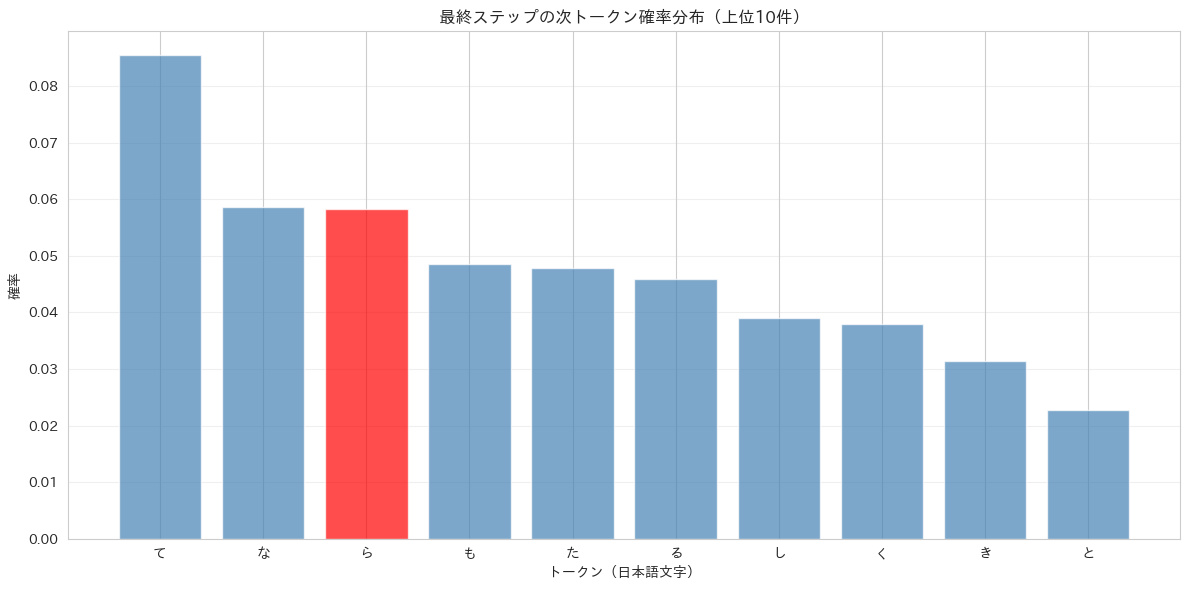


注: 赤色は選択されたトークンを示します


In [5]:
# 最後のステップの確率分布を棒グラフで表示
if all_states:
    last_states = all_states[-1]
    probs = last_states['probs']
    next_token_id = last_states['next_token_id']
    
    # 上位10件を表示
    top_k = 10
    top_indices = np.argsort(probs)[-top_k:][::-1]
    
    # データフレームを作成
    prob_data = []
    for idx in top_indices:
        if idx == analyzer.BOS:
            char = '<BOS>'
        else:
            char = analyzer.uchars[idx]
        prob_data.append({
            'token': char,
            'probability': probs[idx],
            'selected': idx == next_token_id
        })
    
    prob_df = pd.DataFrame(prob_data)
    
    # 棒グラフで可視化
    plt.figure(figsize=(12, 6))
    colors = ['red' if selected else 'steelblue' for selected in prob_df['selected']]
    plt.bar(prob_df['token'], prob_df['probability'], color=colors, alpha=0.7)
    plt.xlabel('トークン（日本語文字）')
    plt.ylabel('確率')
    plt.title(f'最終ステップの次トークン確率分布（上位{top_k}件）')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n注: 赤色は選択されたトークンを示します")

## 生成トークン列の確認

In [6]:
# 生成されたトークン列を表示
print("\n" + "=" * 70)
print("生成トークン列")
print("=" * 70)

tokens_generated = ['<BOS>']
for states in all_states:
    next_token_id = states['next_token_id']
    if next_token_id == analyzer.BOS:
        tokens_generated.append('<BOS>')
    else:
        tokens_generated.append(analyzer.uchars[next_token_id])

print(" → ".join(tokens_generated))
print(f"\n最終生成テキスト: {generated_text}")


生成トークン列
<BOS> → 秋 → に → な → て → ら

最終生成テキスト: 秋になてら


## Plotlyインタラクティブアニメーション

日本語俳句生成の推論プロセスをインタラクティブなアニメーションで可視化します。

In [7]:
# アニメーションフレームのデータを準備
def create_animation_frames():
    """各ステップのアニメーションフレームを作成"""
    frames = []
    
    for step_idx, states in enumerate(all_states):
        # 現在のトークン情報
        token_id = states['token_id']
        next_token_id = states['next_token_id']
        
        if token_id == analyzer.BOS:
            current_char = '<BOS>'
        else:
            current_char = analyzer.uchars[token_id]
        
        if next_token_id == analyzer.BOS:
            next_char = '<BOS>'
        else:
            next_char = analyzer.uchars[next_token_id]
        
        # 次トークン確率分布
        probs = states['probs']
        top_k = 10
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_tokens = [analyzer.uchars[i] if i < len(analyzer.uchars) else '<BOS>' for i in top_indices]
        top_probs = [probs[i] for i in top_indices]
        
        # 選択されたトークンを強調
        colors = ['red' if i == next_token_id else 'steelblue' for i in top_indices]
        
        frames.append({
            'step': step_idx,
            'current_char': current_char,
            'next_char': next_char,
            'top_tokens': top_tokens,
            'top_probs': top_probs,
            'colors': colors,
            'embedding_mean': np.mean(states['embedding']),
            'embedding_std': np.std(states['embedding']),
            'states': states
        })
    
    return frames

animation_frames = create_animation_frames()
print(f"アニメーションフレーム数: {len(animation_frames)}")

アニメーションフレーム数: 5


In [8]:
# Plotlyアニメーションを作成
def create_plotly_animation(frames_data):
    """Plotlyでインタラクティブアニメーションを作成"""
    
    # サブプロットを作成
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('次トークン確率分布（日本語）', 'Embedding統計', 
                       'Attention重み（ヘッド別）', 'モデル処理フロー'),
        specs=[[{'type': 'bar'}, {'type': 'indicator'}],
               [{'type': 'bar'}, {'type': 'table'}]],
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    # 初期フレームのデータ
    frame0 = frames_data[0]
    
    # 1. 次トークン確率分布（棒グラフ）
    fig.add_trace(
        go.Bar(
            x=frame0['top_tokens'],
            y=frame0['top_probs'],
            marker_color=frame0['colors'],
            name='確率',
            hovertemplate='トークン: %{x}<br>確率: %{y:.4f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # 2. Embedding統計（インジケーター）
    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=frame0['embedding_mean'],
            title={'text': "Embedding平均"},
            delta={'reference': 0},
            domain={'x': [0, 1], 'y': [0, 1]}
        ),
        row=1, col=2
    )
    
    # 3. Attention重み（各ヘッド）
    attn_weights = frame0['states']['layer0_attn_weights']
    head_labels = [f'H{i}' for i in range(len(attn_weights))]
    max_weights = [np.max(w) for w in attn_weights]
    
    fig.add_trace(
        go.Bar(
            x=head_labels,
            y=max_weights,
            marker_color='lightblue',
            name='最大重み',
            hovertemplate='ヘッド: %{x}<br>最大重み: %{y:.4f}<extra></extra>'
        ),
        row=2, col=1
    )
    
    # 4. モデル処理フロー（テーブル）
    flow_table = [
        ['ステップ', f"{frame0['step'] + 1}"],
        ['現在トークン', frame0['current_char']],
        ['次トークン', frame0['next_char']],
        ['Embedding平均', f"{frame0['embedding_mean']:.4f}"],
        ['Embedding標準偏差', f"{frame0['embedding_std']:.4f}"]
    ]
    
    fig.add_trace(
        go.Table(
            header=dict(values=['項目', '値'],
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[[row[0] for row in flow_table],
                             [row[1] for row in flow_table]],
                      fill_color='lavender',
                      align='left')
        ),
        row=2, col=2
    )
    
    # アニメーションフレームを作成
    plot_frames = []
    for frame_data in frames_data:
        attn_weights = frame_data['states']['layer0_attn_weights']
        max_weights = [np.max(w) for w in attn_weights]
        
        flow_table = [
            ['ステップ', f"{frame_data['step'] + 1}"],
            ['現在トークン', frame_data['current_char']],
            ['次トークン', frame_data['next_char']],
            ['Embedding平均', f"{frame_data['embedding_mean']:.4f}"],
            ['Embedding標準偏差', f"{frame_data['embedding_std']:.4f}"]
        ]
        
        plot_frames.append(go.Frame(
            data=[
                go.Bar(x=frame_data['top_tokens'], 
                      y=frame_data['top_probs'],
                      marker_color=frame_data['colors']),
                go.Indicator(value=frame_data['embedding_mean'],
                           delta={'reference': 0}),
                go.Bar(x=head_labels, y=max_weights),
                go.Table(
                    cells=dict(values=[[row[0] for row in flow_table],
                                     [row[1] for row in flow_table]])
                )
            ],
            name=str(frame_data['step'])
        ))
    
    fig.frames = plot_frames
    
    # レイアウト設定
    fig.update_layout(
        title_text='俳句モデル：推論プロセス インタラクティブアニメーション',
        height=800,
        showlegend=False,
        updatemenus=[
            {
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': 1000, 'redraw': True},
                                       'fromcurrent': True,
                                       'mode': 'immediate'}],
                        'label': '▶ 再生',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                         'mode': 'immediate',
                                         'transition': {'duration': 0}}],
                        'label': '⏸ 停止',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 87},
                'showactive': False,
                'type': 'buttons',
                'x': 0.1,
                'xanchor': 'right',
                'y': 0,
                'yanchor': 'top'
            }
        ],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'y': 0,
            'xanchor': 'left',
            'currentvalue': {
                'prefix': 'ステップ: ',
                'visible': True,
                'xanchor': 'right'
            },
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'steps': [
                {
                    'args': [[f.name], {
                        'frame': {'duration': 0, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 0}
                    }],
                    'label': str(int(f.name) + 1),
                    'method': 'animate'
                }
                for f in plot_frames
            ]
        }]
    )
    
    # 軸ラベル
    fig.update_xaxes(title_text="トークン", row=1, col=1)
    fig.update_yaxes(title_text="確率", row=1, col=1)
    fig.update_xaxes(title_text="ヘッド", row=2, col=1)
    fig.update_yaxes(title_text="最大Attention重み", row=2, col=1)
    
    return fig

# アニメーションを作成して表示
animation_fig = create_plotly_animation(animation_frames)
animation_fig.show()

print("\n使い方:")
print("- ▶ 再生ボタンでアニメーション開始")
print("- ⏸ 停止ボタンで一時停止")
print("- スライダーで特定のステップに移動")
print("- グラフにカーソルを合わせると詳細情報を表示")


使い方:
- ▶ 再生ボタンでアニメーション開始
- ⏸ 停止ボタンで一時停止
- スライダーで特定のステップに移動
- グラフにカーソルを合わせると詳細情報を表示


## モデル構造図フロー

Plotlyで俳句モデルの処理フローを視覚化します。

In [9]:
# モデル構造図のアニメーション
def create_flow_animation(frames_data):
    """モデル構造フローのアニメーション"""
    
    # 処理ステージの定義
    stages = [
        'Input Token (日本語文字)',
        'Token + Position Embedding',
        'RMSNorm',
        'Multi-Head Attention',
        'Residual Connection 1',
        'RMSNorm',
        'MLP (FC1→ReLU→FC2)',
        'Residual Connection 2',
        'LM Head',
        'Softmax',
        'Token Sampling'
    ]
    
    # 各ステージのY座標
    y_positions = list(range(len(stages)))[::-1]  # 上から下へ
    
    # 初期フレーム
    fig = go.Figure()
    
    # ステージを表示
    fig.add_trace(
        go.Scatter(
            x=[1] * len(stages),
            y=y_positions,
            mode='markers+text',
            marker=dict(size=40, color='lightblue', line=dict(width=2, color='steelblue')),
            text=stages,
            textposition='middle right',
            textfont=dict(size=11),
            hovertemplate='%{text}<extra></extra>',
            name='処理ステージ'
        )
    )
    
    # 矢印を追加
    for i in range(len(y_positions) - 1):
        fig.add_annotation(
            x=1, y=y_positions[i],
            ax=1, ay=y_positions[i+1],
            xref='x', yref='y',
            axref='x', ayref='y',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='gray'
        )
    
    # アニメーションフレーム
    plot_frames = []
    for frame_idx, frame_data in enumerate(frames_data):
        # 現在アクティブなステージを強調（例：ステージ3をハイライト）
        active_stage = (frame_idx * 3) % len(stages)  # 簡易的な進行
        
        colors = ['red' if i == active_stage else 'lightblue' for i in range(len(stages))]
        sizes = [60 if i == active_stage else 40 for i in range(len(stages))]
        
        stage_info = stages[active_stage]
        
        plot_frames.append(go.Frame(
            data=[
                go.Scatter(
                    x=[1] * len(stages),
                    y=y_positions,
                    mode='markers+text',
                    marker=dict(size=sizes, color=colors, 
                              line=dict(width=3, color='steelblue')),
                    text=stages,
                    textposition='middle right',
                    textfont=dict(size=11)
                )
            ],
            name=str(frame_idx),
            layout=go.Layout(
                title_text=f'ステップ {frame_idx + 1}: {stage_info}<br>現在: {frame_data["current_char"]} → 次: {frame_data["next_char"]}'
            )
        ))
    
    fig.frames = plot_frames
    
    # レイアウト
    fig.update_layout(
        title='俳句モデル：処理フロー（トークン生成の流れ）',
        xaxis=dict(visible=False, range=[0, 3]),
        yaxis=dict(visible=False, range=[-1, len(stages)]),
        height=700,
        showlegend=False,
        updatemenus=[
            {
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': 800, 'redraw': True},
                                       'fromcurrent': True}],
                        'label': '▶ 再生',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                         'mode': 'immediate'}],
                        'label': '⏸ 停止',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 87},
                'type': 'buttons',
                'x': 0.1,
                'y': 0,
                'xanchor': 'right',
                'yanchor': 'top'
            }
        ],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'y': 0,
            'currentvalue': {
                'prefix': 'ステップ: ',
                'visible': True
            },
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'steps': [
                {
                    'args': [[f.name], {
                        'frame': {'duration': 0, 'redraw': True},
                        'mode': 'immediate'
                    }],
                    'label': str(int(f.name) + 1),
                    'method': 'animate'
                }
                for f in plot_frames
            ]
        }]
    )
    
    return fig

# フローアニメーションを作成して表示
flow_fig = create_flow_animation(animation_frames)
flow_fig.show()

## まとめ

このNotebookでは、日本語俳句生成の推論プロセスを完全に可視化しました：

### 実装した機能
1. **基本的なステップ表示**: 各ステップでの統計情報を詳細に表示
2. **Plotlyインタラクティブアニメーション**: 
   - 4つのサブプロット（確率分布、Embedding統計、Attention重み、処理フロー）
   - 再生/停止ボタンで制御
   - スライダーで任意のステップに移動
   - ホバーで詳細情報表示
3. **モデル構造フローアニメーション**:
   - 11段階の処理ステージを視覚化
   - 現在アクティブなステージを赤色で強調
   - 日本語文字のトークン遷移を表示

### 観察ポイント
- 日本語俳句生成時にAttentionヘッドがどのように過去の文字に注目しているか
- 確率分布がどの程度集中しているか（温度パラメータの影響）
- 各レイヤーでの日本語文字の特徴表現の変化
- モデル内部の処理フローの理解

### 技術的特徴
- **完全にインタラクティブ**: Plotlyによる動的アニメーション
- **Notebook内で実行可能**: 外部ファイル不要
- **細かい制御**: フレームごとに停止・再生・移動可能
- **複数の視点**: 確率、統計、Attention、フローを同時表示
- **日本語対応**: 日本語文字の生成プロセスを正しく可視化

次のNotebookでは、日本語文字間の条件付き確率分布を可視化します。